## **GMVAE**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.nn import softmax, softplus
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
!pip install mdtraj
import mdtraj as md

from google.colab import output
output.enable_custom_widget_manager()
!pip install nglview==3.0.8; pip install ipywidgets==7.7.2
import nglview as nv

!pip install deeptime
!pip install simpletraj
!pip install mdanalysis


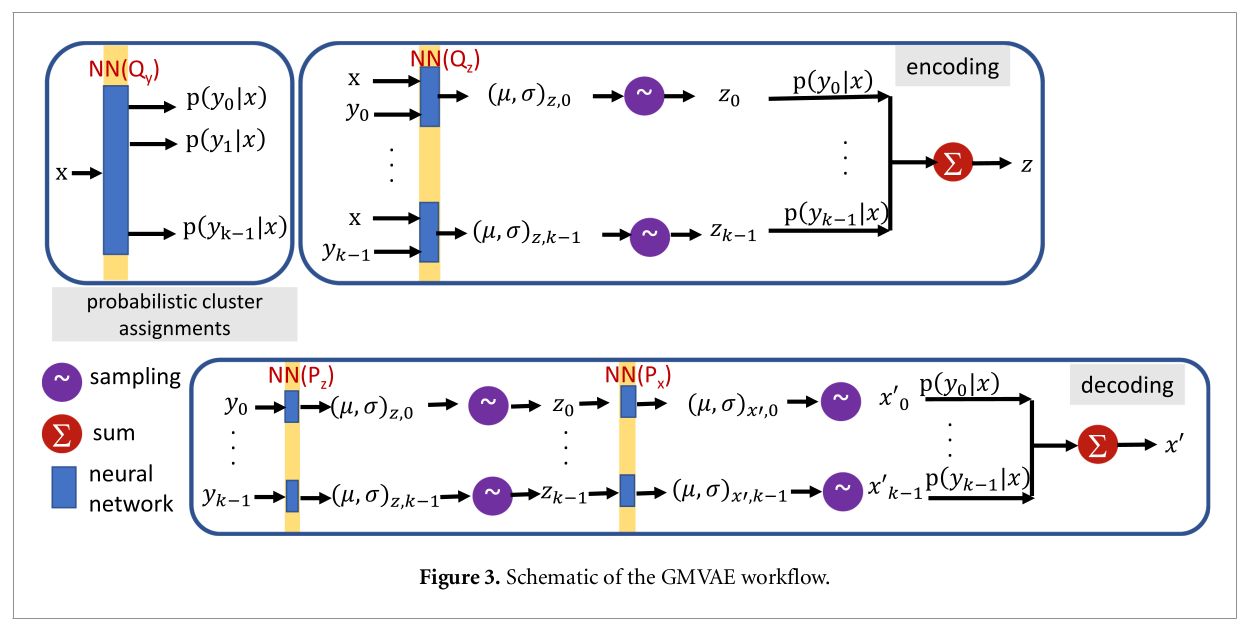

## Functions


In [2]:
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import align,contacts,distances

class Gaussian():
    """
    https://github.com/Balasubra/MolDyn_Rigidity/tree/main
    https://www.sciencedirect.com/science/article/pii/S0006349506726315#fig1
    """
    def __init__(self,Mobile,Reference,sfactor=5.0):
        self.mob , self.ref  = Mobile , Reference
        self.fac , self.sel  = sfactor , 'name CA'
        self.nframes = self.mob.trajectory.n_frames
        self.natoms  = self.mob.trajectory.n_atoms

        # Index of Ca atoms
        self.ndx   = np.where( self.mob.atoms.names == 'CA' )[0]
        self.size  = self.ndx.size

        # Get positions
        self.mpos = self.mob.atoms.positions[ self.ndx ]
        self.rpos = self.ref.atoms.positions[ self.ndx ]

        # Output data
        self.result = np.zeros( (self.nframes,2))
        self.coords = np.zeros( (self.nframes,self.natoms,3) , dtype=np.float32 )
        self.weight = np.zeros( (self.nframes,self.size))

    def g_weights(self):
        #Squared Displacement
        disp = (self.rpos - self.mpos)**2
        dsum = disp.sum(axis=1)
        return np.exp(-(dsum)/self.fac)

    def g_fits(self,frame):
        # Forward to specific frame
        self.mob.universe.trajectory[ frame ]
        wRMSD, sRMSD, Conv = 100, 0 , 0
        # Initial weight 1 for all Ca atoms
        Wgs = np.ones( self.size , dtype=np.float16 )

        # Start iterations
        for i in range(50):
            # alignto returns rot.matrix and RMSD
            _,RMSD = align.alignto(self.mob , self.ref , select=self.sel , weights=Wgs, match_atoms=True)

            # Updated positions,weights
            self.mpos = self.mob.atoms.positions[ self.ndx ]
            Wgs = self.g_weights()

            if i==0:
                # First iteration, assign RMSD to std.RMSD
                sRMSD = RMSD

            # Check convergence
            if (wRMSD - RMSD) < 0.0001:
                Conv = i+1
                self.coords[frame] = self.mob.atoms.positions
                self.weight[frame] = Wgs
                break

            wRMSD = RMSD
        self.result[frame,:] =  sRMSD,wRMSD

    def update(self,ts):
        ts.positions = self.coords[ts.frame]
        return ts

    def conclude(self,prefix='gfit',output=False):
        columns = ['sRMSD' , 'wRMSD' ]
        self.df = pd.DataFrame(self.result , columns=columns)
        self.wg = pd.DataFrame(self.weight, columns=[ f"R{i}" for i in range(1,self.size+1) ] )

        if output:
            self.df.to_csv( f'{prefix}_rms.csv',index_label='Frame')
            self.wg.to_csv( f'{prefix}_wgs.csv',index=False)
            self.mob.trajectory.add_transformations(self.update)
            sel = self.mob.select_atoms("all")
            with mda.Writer(f'{prefix}_fit.xtc', sel.n_atoms) as W:
                for ts in self.mob.trajectory:
                    W.write(sel)
            print( f"Fitted traj is writtein as {prefix}_fit.xtc")

        return self.df

    def fitted_traj(self):
        """
        Return the aligned trajectory as a numpy array of shape [frames, atoms, xyz].

        Returns:
            np.ndarray: The fitted trajectory coordinates.
        """
        return self.coords

## MODEL

In [3]:
class GMVAE(tf.keras.Model):
    def __init__(self, k, n_z, n_x, qy_dims, qz_dims, pz_dims, px_dims, r_nent, batch_size, lr):
        super(GMVAE, self).__init__()

        """Build a GMM VAE model.

        Args:
            k (int): Number of mixture components.
            n_x (int): Number of observable dimensions.
            n_z (int): Number of hidden dimensions.
            qy_dims (iterable of int): Iterable of hidden dimensions in qy subgraph.
            qz_dims (iterable of int): Iterable of hidden dimensions in qz subgraph.
            pz_dims (iterable of int): Iterable of hidden dimensions in pz subgraph.
            px_dims (iterable of int): Iterable of hidden dimensions in px subgraph.
            r_nent (float): A constant for weighting negative entropy term in the loss.
            batch_size (int): Number of samples in each batch.
            lr (float): Learning rate.
        """

        self.k = k
        self.n_x = n_x
        self.n_z = n_z
        self.qy_dims = qy_dims
        self.qz_dims = qz_dims
        self.pz_dims = pz_dims
        self.px_dims = px_dims
        self.r_nent = r_nent
        self.batch_size = batch_size
        self.lr = lr

        # LAYERS:

        ## NN(Qy)
        use_batch_norm = True
        self.qy_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(qy_dims):
            self.qy_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                 use_bias=not use_batch_norm,
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.qy_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.qy_nn.add(tf.keras.layers.Dense(k, activation='relu', kernel_initializer=None))

        ## NN(Qz)
        self.y_transform = tf.keras.layers.Dense(self.k, activation=None, kernel_initializer=None)
        self.qz_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(qz_dims):
            self.qz_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                    kernel_initializer=None))
            if use_batch_norm:
                self.qz_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.zm_layer = tf.keras.layers.Dense(n_z, activation=None, kernel_initializer=None)
        self.zv_layer = tf.keras.layers.Dense(n_z, activation=tf.nn.softplus, kernel_initializer=None)

        ## NN(Pz)
        self.pz_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(pz_dims):
            self.pz_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.pz_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.zm_prior_layer = tf.keras.layers.Dense(n_z, activation=None, kernel_initializer=None)
        self.zv_prior_layer = tf.keras.layers.Dense(n_z, activation=tf.nn.softplus, kernel_initializer=None)

        ## NN(Px)
        self.px_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(px_dims):
            self.px_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                 use_bias=not use_batch_norm,
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.px_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.xm_layer = tf.keras.layers.Dense(n_x, activation=None, kernel_initializer=None)
        self.xv_layer = tf.keras.layers.Dense(n_x, activation=tf.nn.softplus, kernel_initializer=None)

    @staticmethod
    def log_normal(x, mu, var, axis=-1):
        return -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi) + tf.math.log(var) + tf.square(x - mu) / var, axis)

    def loss_function(self, k, x, xm, xv, z, zm, zv, zm_prior, zv_prior):
        return -self.log_normal(x, xm, xv) + self.log_normal(z, zm, zv) - self.log_normal(z, zm_prior, zv_prior) - tf.math.log(1/k)

    def call(self, data, training=None):
        y_ = tf.fill(tf.stack([tf.shape(data)[0], self.k]), 0.0)
        qy_logit = self.qy_nn(data)    #shape: n_frames,k
        qy = tf.nn.softmax(qy_logit)   #shape: n_frames,k

        zm_list, zv_list, z_list = [], [], []
        zm_prior_list, zv_prior_list, z_prior_list = [], [], []
        xm_list, xv_list, x_list = [], [], []

        for i in range(self.k):
            y = tf.add(y_, tf.constant(np.eye(self.k)[i], dtype=tf.float32, name=f'hot_at_{i:d}')) #shape: n_frames,5


            ###Encoders###
            ##QZ
            h0 = self.y_transform(y)
            xy = tf.concat([data, h0], 1)
            qz_logit = self.qz_nn(xy)         #shape: n_frames,5
            zm = self.zm_layer(qz_logit)        #shape: n_frames,n_z
            zv = self.zv_layer(qz_logit)        #shape: n_frames,n_z
            zm_list.append(zm); zv_list.append(zv)
            #Sample
            z_sample = tf.random.normal(tf.shape(zm), zm, stddev=tf.sqrt(zv))
            z_sample.set_shape(zm.get_shape())
            zs = z_sample                           #shape: n_frames,1
            z_list.append(zs)


            ### Decoders###
            ##PZ
            pz_logit = self.pz_nn(y)                      #shape: n_frames,1
            zm_prior = self.zm_prior_layer(pz_logit)      #shape: n_frames,n_z
            zv_prior = self.zv_prior_layer(pz_logit)      #shape: n_frames,n_z
            zm_prior_list.append(zm_prior); zv_prior_list.append(zv_prior)
            #Sample
            pz_sample = tf.random.normal(tf.shape(zm_prior), zm_prior, stddev=tf.sqrt(zv_prior))
            pz_sample.set_shape(zm_prior.get_shape())
            z_prior = pz_sample                           #shape: n_frames,1
            z_prior_list.append(z_prior)

            ##PX
            px_logit = self.px_nn(z_prior)      #shape: n_frames,1
            xm = self.xm_layer(px_logit)        #shape: n_frames,n_x
            xv = self.xv_layer(px_logit)        #shape: n_frames,n_x
            xm_list.append(xm); xv_list.append(xv)
            #Sample
            x_sample = tf.random.normal(tf.shape(xm), xm, stddev=tf.sqrt(xv))
            x_sample.set_shape(xm.get_shape())
            xs = x_sample                           #shape: n_frames,1
            x_list.append(xs)


        nent = -tf.nn.softmax_cross_entropy_with_logits(labels=qy, logits=qy_logit)

        losses = [None] * self.k

        for i in range(self.k):
            losses[i] = self.loss_function(self.k, data, xm_list[i], xv_list[i], z_list[i], zm_list[i], zv_list[i], zm_prior_list[i], zv_prior_list[i])

        total_loss = tf.add_n([nent*self.r_nent] + [qy[:, i] * losses[i] for i in range(self.k)]) #?

        return qy_logit, qy, zm_list, zv_list, z_list, x_list, zm_prior_list, zv_prior_list, z_prior_list, xm_list, xv_list, total_loss, nent

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            _, _, _, _, _, _, _, _, _, _, _, total_loss, nent = self.call(data, training=True)


        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return tf.reduce_mean(total_loss)

    def train(self, train_dataset, epochs):
      losses = np.empty(epochs)
      for epoch in range(epochs):
          if epoch == 0:
              print("Training:")

          epoch_loss = 0

          # Iterate over the batches of the dataset.
          for step, x_batch_train in enumerate(train_dataset):
              loss_value = self.train_step(x_batch_train)

              epoch_loss += loss_value

          losses[epoch] = epoch_loss / len(train_dataset)

          if epoch % 10 == 0 or epoch == 0:
              print(f"Loss for epoch {epoch}: {losses[epoch]}")

      return losses, epoch_loss


## INPUT

In [4]:
apo_xtc_path = "/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.xtc"
apo_pdb_path = "/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb"

holo_xtc_path = "/content/drive/MyDrive/PhD/AI-ML/GMVAE//WT_holo_CA_ChainsA.xtc"
holo_pdb_path = "/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_holo_CA_ChainsA.pdb"


In [ ]:
# Fit Apo
mobile = mda.Universe(apo_pdb_path, apo_xtc_path)
reference = mda.Universe(apo_pdb_path)

# Initialize the Gaussian wRMSD alignment
gaussian_fit = Gaussian(Mobile=mobile, Reference=reference, sfactor=5.0)

# Perform alignment for all frames
for frame in range(mobile.trajectory.n_frames):
    gaussian_fit.g_fits(frame)

traj_apo = gaussian_fit.fitted_traj()

gaussian_fit.conclude(prefix='/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA', output=True)

## Fit Holo
mobile = mda.Universe(holo_pdb_path, holo_xtc_path)
reference = mda.Universe(apo_pdb_path)

# Initialize the Gaussian wRMSD alignment
gaussian_fit = Gaussian(Mobile=mobile, Reference=reference, sfactor=5.0)

# Perform alignment for all frames
for frame in range(mobile.trajectory.n_frames):
    gaussian_fit.g_fits(frame)

traj_holo = gaussian_fit.fitted_traj()

gaussian_fit.conclude(prefix='/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_holo_CA_ChainsA', output=True)

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Fitted traj is writtein as /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_fit.xtc
Fitted traj is writtein as /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_holo_CA_ChainsA_fit.xtc


sRMSD  wRMSD
0       220.757723  100.0
1       221.105083  100.0
2       221.205222  100.0
3       220.964291  100.0
4       220.986393  100.0
...            ...    ...
199996  219.620924  100.0
199997  219.985964  100.0
199998  219.986074  100.0
199999  219.460116  100.0
200000  219.483132  100.0

[200001 rows x 2 columns]

from matplotlib import pyplot as plt
_df_0['sRMSD'].plot(kind='hist', bins=20, title='sRMSD')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['wRMSD']
  ys = series['sRMSD']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('wRMSD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('wRMSD')
_ = plt.ylabel('sRMSD')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['wRMSD']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'wRMSD'}, axis=1)
              .sort_values('wRMSD', ascending=True))
  xs = counted['wRMSD']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('wRMSD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('wRMSD')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['sRMSD'].plot(kind='line', figsize=(8, 4), title='sRMSD')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
## DATA SETUP
tf.random.set_seed(42)

# cryst_2vgb = md.load("/content/drive/MyDrive/PhD/AI-ML/GMVAE/2vgb (2).pdb")
# cryst_2vgb = cryst_2vgb.atom_slice(cryst_2vgb.topology.select("name CA && chainid 0"))

# cryst_8tbs = md.load("/content/drive/MyDrive/PhD/AI-ML/GMVAE/8tbs.pdb")
# cryst_8tbs = cryst_8tbs.atom_slice(cryst_8tbs.topology.select("name CA && chainid 0"))

traj_apo = md.load("/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_fit.xtc",
              top="/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb")
traj_holo = md.load("/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_holo_CA_ChainsA_fit.xtc",
                    top="/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_holo_CA_ChainsA.pdb")

# atom_indices = traj_apo.topology.select("name CA")
# traj_holo = traj_holo.superpose(traj_apo, frame=0, atom_indices=atom_indices)

#cryst_2vgb = cryst_2vgb.superpose(traj_apo, frame=0, atom_indices=atom_indices)
topology = md.load(apo_pdb_path)
traj = np.concatenate((traj_apo.xyz, traj_holo.xyz), axis=0)
traj_apo = md.Trajectory(traj, topology=topology.topology)

data = traj_apo.xyz #- np.mean(traj_apo.xyz, axis=0)
data = np.reshape(data, (data.shape[0], -1))

# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
data=data[::4]

data = tf.convert_to_tensor(data)
data = tf.cast(data, dtype=tf.float32)


In [ ]:
########################################### MAIN ########################################

# Hyperparameters
k, n_x, n_z, n_epochs = 8, 1551, 2, 100
qy_dims = [32]
qz_dims = [16, 16]
pz_dims = [16, 16]
px_dims = [128]
r_nent = 2
batch_size = 1551
lr = 1e-4
train_model = True

#Train and Test data:
train_size = int(0.8 * len(data))
x_train, x_test = data[:train_size], data[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=len(data))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test))

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Instantiate Model
model = GMVAE(k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent, batch_size=batch_size, lr=lr)

# Optimizer
model.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


In [ ]:
# Train Model
if train_model:
    losses, epoch_loss = model.train(train_dataset, epochs=n_epochs)
    model.save_weights(f'/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_trained_model.weights.h5')

    #Training: Loss vs Epoch Plot
    plt.plot(range(0,len(losses)), losses)
    plt.ylabel('Total Loss')
    plt.xlabel('Epochs')
    plt.title('Training')
    plt.show()
else:
    model(np.random.rand(batch_size, n_x))
    model.load_weights(f'/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_trained_model.weights.h5')

model.summary()

In [ ]:
# Testing:
data = tf.convert_to_tensor(data)
qy_logit, qy, _, _, z_list, x_list, _, _, _, _, _, total_loss, nent = model.call(data)
y_pred = np.argmax(qy, axis=1)
print(np.unique(y_pred))


In [ ]:
# Latent and Reconstruction Calculations:

#Latent Space (z)
z = np.zeros(z_list[0].shape)
for z_i in range(z_list[0].shape[1]):
    for y_i in range(qy.shape[1]):
        z[:, z_i] += z_list[y_i][:,z_i]*qy[:,y_i]

#Reconstruction (x')
# x = np.zeros(x_list[0].shape)
# for x_i in range(x_list[0].shape[1]):
#     for y_i in range(qy.shape[1]):
#         x[:, x_i] += x_list[y_i][:,x_i]*qy[:,y_i]


In [ ]:
y_unq, y_pred = np.unique(y_pred, return_inverse=True)

# Create figure and subplots
gs = gridspec.GridSpec(4, 4)
fig = plt.figure(figsize=(12, 10))
ax_main = plt.subplot(gs[1:4, :3])

# Color map and normalization
cmap = plt.get_cmap('viridis', len(y_unq))
boundaries = np.arange(len(y_unq) + 1) - 0.5
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Scatter plot
sc = ax_main.scatter(z[:, 0], z[:, 1], c=y_pred, norm=norm, cmap=cmap, alpha=1, s=2)

# Add colorbar
pos = ax_main.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(len(y_unq)))
cbar.set_label('Clusters')

# Set axis labels
ax_main.set_xlabel('z1', labelpad=20)
ax_main.set_ylabel('z2', labelpad=20)

# Display the plot
plt.show()
print(y_unq)

[3]


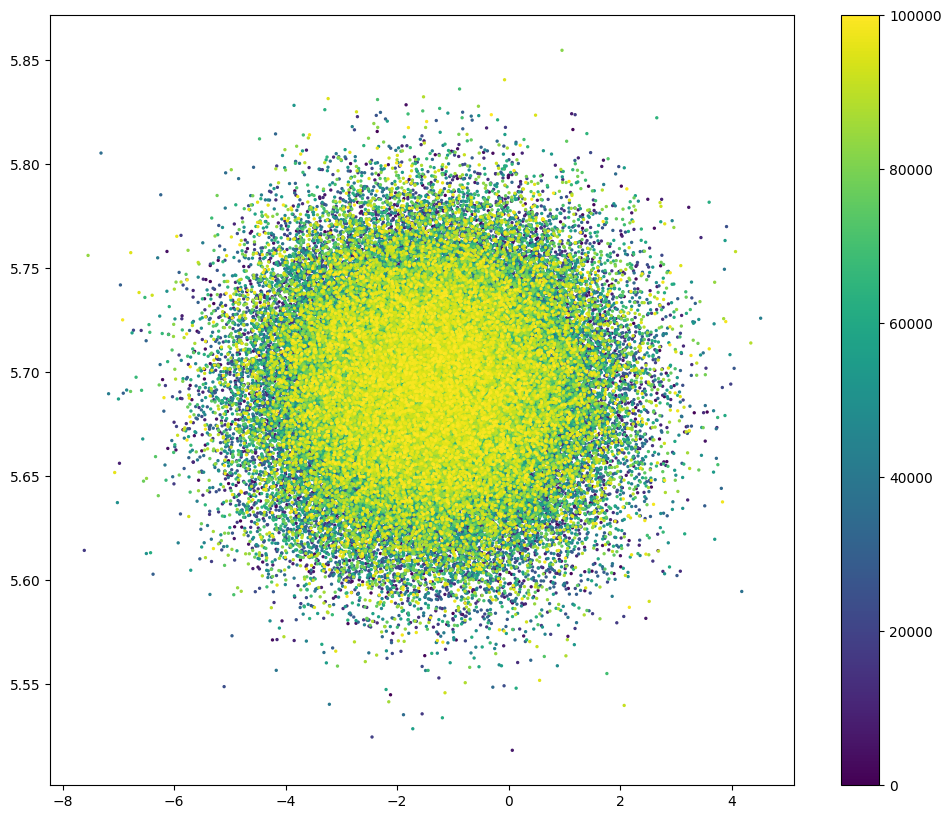

In [11]:

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z[:, 0], z[:, 1], c=np.arange(len(z)), cmap='viridis', alpha=1, s=2)
plt.colorbar(scatter)
plt.show()

In [12]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Assume z is the latent space representation (e.g., numpy array)
n_components = 5  # Number of Gaussian clusters
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

# Fit the GMM to the latent space
gmm.fit(z)

# Assign points to clusters
cluster_labels = gmm.predict(z)

# Get likelihoods (to identify outliers later)
log_likelihoods = gmm.score_samples(z)

# Define a threshold for outliers (e.g., 2 standard deviations below the mean)
threshold = np.mean(log_likelihoods) - 2 * np.std(log_likelihoods)

# Filter points with likelihood above the threshold
non_outliers = log_likelihoods > threshold
z_filtered = z[non_outliers]
cluster_labels_filtered = cluster_labels[non_outliers]

print(f"Original points: {len(z)}, Filtered points: {len(z_filtered)}")

# # Scatter plot of the filtered data
# for cluster_id in np.unique(cluster_labels_filtered):
#     cluster_points = z_filtered[cluster_labels_filtered == cluster_id]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

# # Optionally plot outliers
# outliers = z[~non_outliers]
# plt.scatter(outliers[:, 0], outliers[:, 1], color='grey', label="Outliers", s=1, alpha=0.1)

# plt.legend()
# plt.title("Clustered Data with Outliers Removed")
# plt.show()

# Make a trajectory without transition states
unique_clusters = np.unique(cluster_labels_filtered)
print(unique_clusters)
for cluster_id in unique_clusters:
    # Get indices of frames belonging to the current cluster
    cluster_indices = np.where(cluster_labels_filtered == cluster_id)[0]

    # Create a new trajectory for this cluster
    traj_cluster = md.Trajectory(traj_apo.xyz[cluster_indices], topology=traj_apo.topology)

    # Save the trajectory to a file
    output_filename = f"/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_{cluster_id}.xtc"
    traj_cluster.save_xtc(output_filename)

    print(f"Saved trajectory for cluster {cluster_id} with {len(cluster_indices)} frames: {output_filename}")

Original points: 100001, Filtered points: 95451
[0 1 2 3 4]
Saved trajectory for cluster 0 with 8982 frames: /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_0.xtc
Saved trajectory for cluster 1 with 29746 frames: /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_1.xtc
Saved trajectory for cluster 2 with 25091 frames: /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_2.xtc
Saved trajectory for cluster 3 with 8048 frames: /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_3.xtc
Saved trajectory for cluster 4 with 23584 frames: /content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_4.xtc


## Visualize

In [ ]:
!pip install simpletraj

xtc_file = '/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_metastable_cluster_0.xtc'
pdb_file = '/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb'

# Create an NGLView widget
view = nv.show_simpletraj(nv.SimpletrajTrajectory(xtc_file, pdb_file), gui=True)

view.add_representation(repr_type='tube', colorScheme = 'atomindex')
view._remote_call('setSize', target='Widget', args=['800px','600px'])
view


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpletraj: filename=simpletraj-0.5-cp310-cp310-linux_x86_64.whl size=193647 sha256=289dd0dd01552edc51e978953c12bac75ad6f5c807c01d027192a65251ba1ab4
  Stored in directory: /root/.cache/pip/wheels/da/e5/d9/e3dfdf1856baa71af0df8f0109372732eea11a7f8ab406cd54
Successfully built simpletraj


NGLWidget(max_frame=37737)

## Projections

In [13]:
# Calculate centroids
y_unq = np.unique(y_pred)
centroids = np.array([z[y_pred == label].mean(axis=0) for label in y_unq])

# Manual interpolation control: [start_index, end_index]
interp = [[0, 2], [3, 4], [2, 4]]  # Example: Connect centroid 0 to 1, and 1 to 2

# Generate interpolation vectors based on the defined pairs
interpolation_vector = []
for pair in interp:
    start, end = pair
    interp_segment = np.linspace(centroids[start], centroids[end], num=20)  # 20 points
    interpolation_vector.append(interp_segment)

# Plot data, centroids, and manual interpolation
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(z[:, 0], z[:, 1], c=y_pred, cmap='viridis', label='Data Points', alpha=0.6)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', label='Centroids', s=100, edgecolor='black')

# Plot interpolation lines for each pair
for idx, segment in enumerate(interpolation_vector):
    plt.plot(
        segment[:, 0],  # x-coordinates of the interpolated segment
        segment[:, 1],  # y-coordinates of the interpolated segment
        '-o', label=f'{interp[idx][0]} → {interp[idx][1]}',
    )

plt.xlabel('Data Dimension 1')
plt.ylabel('Data Dimension 2')
plt.title('Clusters, Centroids, and Manual Interpolation')
plt.legend()
plt.grid(True)
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
# Initialize a list to store the closest point indices for each interpolation segment
closest_indices = []

for idx, segment in enumerate(interpolation_vector):
    segment_indices = []
    for interp_idx, interp_point in enumerate(segment):
        # Compute distances
        distances = np.linalg.norm(z - interp_point, axis=1)  # Euclidean distance
        closest_idx = np.argmin(distances)

        segment_indices.append(closest_idx)
    closest_indices.append(segment_indices)
    name = f"{interp[idx][0]}_{interp[idx][1]}"

    print(f"{name} | {segment_indices}")

# Convert to a NumPy array for easier manipulation
closest_indices = np.array(closest_indices)

# Save trajectories with meaningful names
for i in range(len(closest_indices)):
    traj_i = md.Trajectory(traj_apo.xyz[closest_indices[i]], topology=traj_apo.topology)
    traj_i.save_xtc(f"/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_transition_{interp[i]}.xtc")

# Plot data, centroids, and manual interpolation
plt.figure(figsize=(10, 6))
plt.scatter(z[:, 0], z[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', label='Centroids', s=100, edgecolor='black')
for i, ts in zip(closest_indices, interp):
    plt.plot(z[i, 0], z[i, 1], '-o', label=f'{ts}')

plt.xlabel('Data Dimension 1')
plt.ylabel('Data Dimension 2')
plt.title('Clusters, Centroids, and Manual Interpolation')
plt.legend()
plt.grid(True)
plt.show()


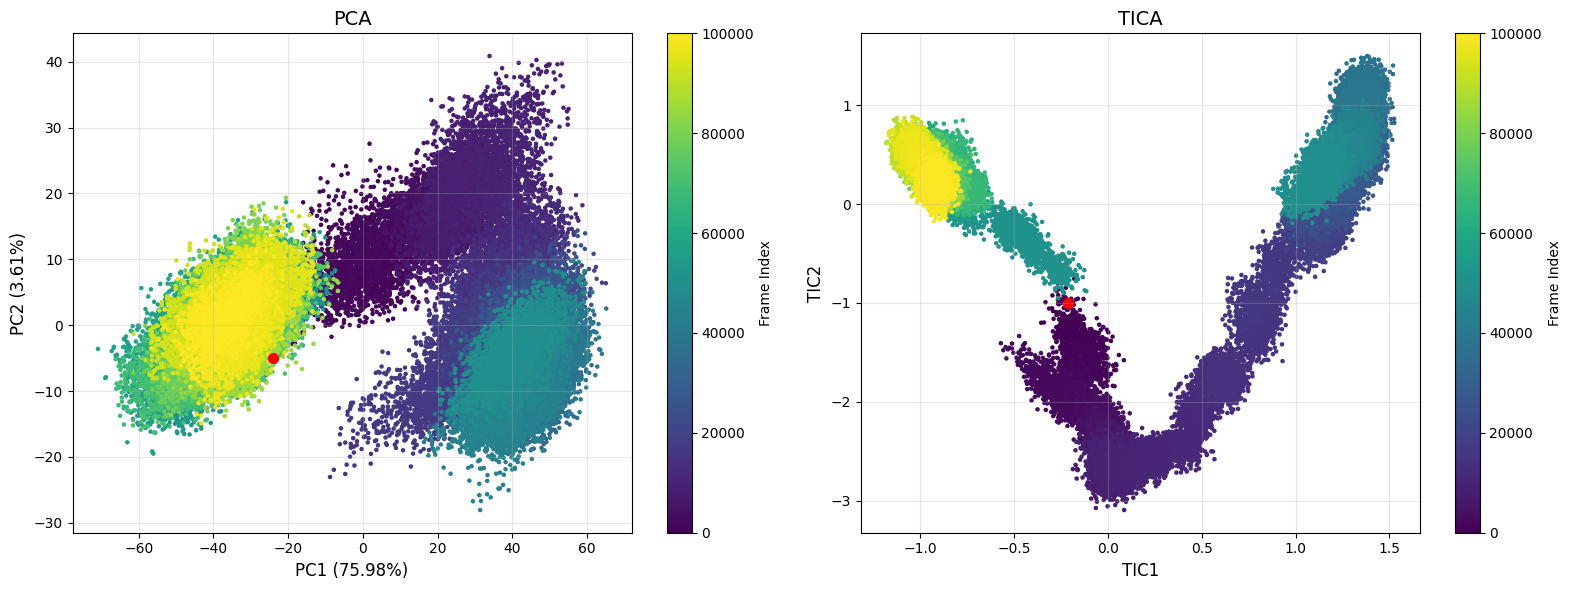

In [ ]:
from sklearn.decomposition import PCA
from deeptime.decomposition import TICA

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)
explained_variance = 100*pca.explained_variance_ratio_

# TICA
tica = TICA(dim=2, lagtime=50)
tica.fit(data.numpy())
tica_model = tica.fetch_model()
tica_components = tica_model.transform(data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# PCA
sc = axes[0].scatter(principal_components[:, 0], principal_components[:, 1],
                     c=np.arange(len(principal_components)), cmap='viridis', s=5)
axes[0].scatter(principal_components[0, 0], principal_components[0, 1], s=50, color='red')
axes[0].set_title("PCA", fontsize=14)
axes[0].set_xlabel(f"PC1 ({explained_variance[0]:.2f}%)", fontsize=12)
axes[0].set_ylabel(f"PC2 ({explained_variance[1]:.2f}%)", fontsize=12)
axes[0].grid(alpha=0.3)
plt.colorbar(sc, ax=axes[0], label="Frame Index")
# TICA
sc = axes[1].scatter(tica_components[:, 0], tica_components[:, 1],
                     c=np.arange(len(tica_components)), cmap='viridis', s=5)
axes[1].scatter(tica_components[0, 0], tica_components[0, 1], s=50, color='red')
axes[1].set_title("TICA", fontsize=14)
axes[1].set_xlabel("TIC1", fontsize=12)
axes[1].set_ylabel("TIC2", fontsize=12)
axes[1].grid(alpha=0.3)
plt.colorbar(sc, ax=axes[1], label="Frame Index")
plt.tight_layout()
plt.show()

In [ ]:
centroid_indices = [closest_indices[2][0], closest_indices[2][-1],
                    closest_indices[1][0], closest_indices[5][-1]]
print(centroid_indices)
distances = md.compute_contacts(traj_apo[centroid_indices])
sq_dist = md.geometry.squareform(distances[0], distances[1])

diff_sq_dist = []
for c, i in enumerate(sq_dist):
   d = c+1
   if d == c+1:
      try:
         diff_sq_dist.append(sq_dist[c] - sq_dist[c+1])
      except:
        break

num_plots = len(diff_sq_dist)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, ax in enumerate(axes[:num_plots]):
  im = ax.pcolormesh(diff_sq_dist[i])
  plt.colorbar(im, ax=ax)
plt.show()

[4293, 45432, 75868, 147721]


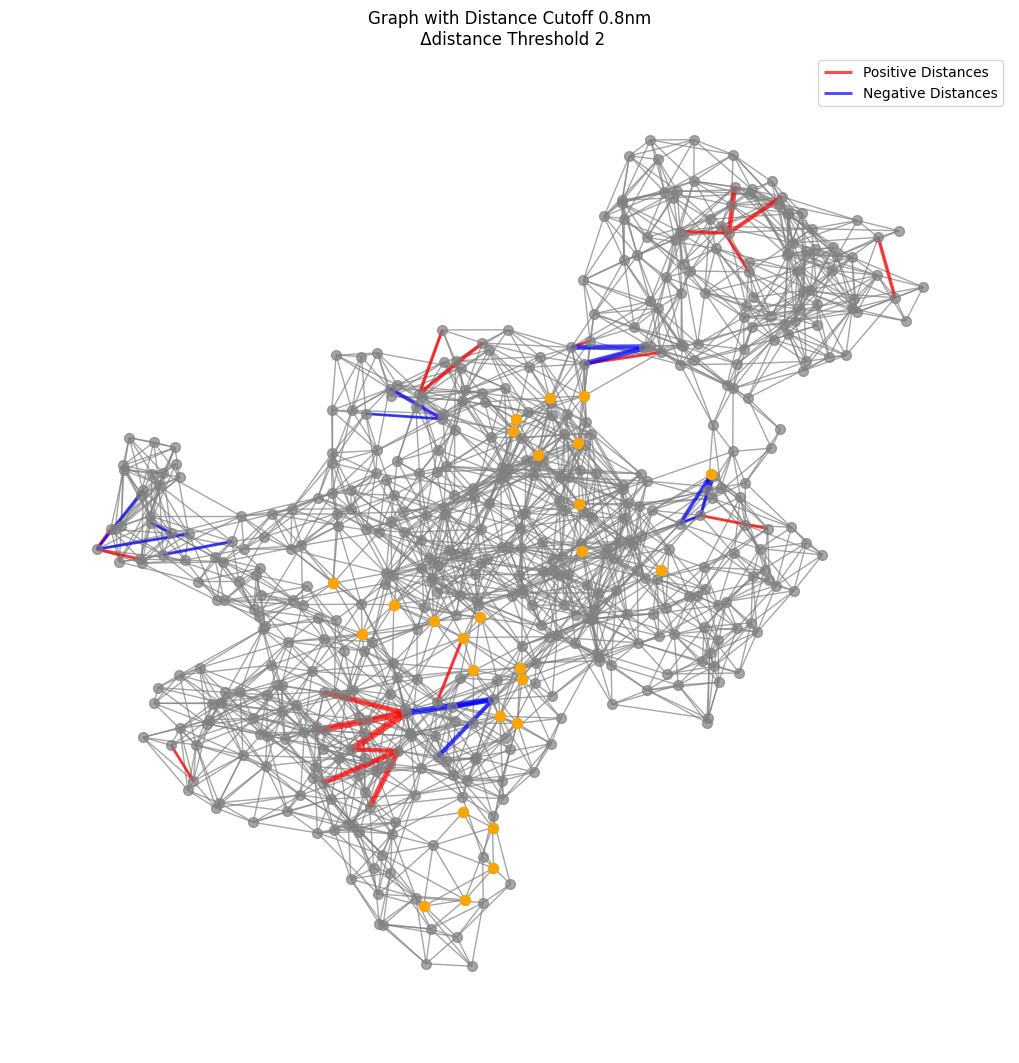

[(57, 61), (57, 62), (57, 79), (57, 81), (60, 80), (64, 433), (119, 123), (119, 157), (119, 158), (120, 157), (120, 158), (141, 144), (141, 147), (141, 148), (146, 535), (146, 538), (146, 539), (147, 539), (147, 542), (147, 543), (188, 234), (212, 228), (213, 227), (213, 228), (213, 229), (213, 230), (221, 342), (253, 343), (255, 342), (256, 343), (346, 350), (347, 350), (373, 387), (373, 390), (507, 514), (548, 573)]


In [ ]:
import networkx as nx
from scipy.spatial import distance_matrix

# test_dccm = np.load("WT_apo_CA_ChainsA_DRY_imagedFit_dt1_pdccm.npy")
diff_dccm = diff_sq_dist[0] #test_dccm - xhat_dccm
cutoff = 0.8
threshold = 2

# Extract x, y, and z coordinates from the PDB file
pdb = md.load("/content/drive/MyDrive/PhD/AI-ML/AE/Hyperparameter Optimization/WT_apo_CA_ChainsA_DRY_imagedFit.pdb")
x = pdb.xyz[:, :, 0]
y = pdb.xyz[:, :, 1]
z = pdb.xyz[:, :, 2]
pos = np.vstack((x, y)).T
coords = np.vstack((x, y, z)).T

# Calculate pairwise distances
distances = distance_matrix(coords, coords)

# Filter pairs based on the distance cutoff
pairs = np.argwhere((distances < cutoff) & (distances > 0))

# Create a graph
G = nx.Graph()
for i, coord in enumerate(pos):
    G.add_node(i, pos=coord)
G_positive = nx.Graph()
for i, coord in enumerate(pos):
    G_positive.add_node(i, pos=coord)
G_negative = nx.Graph()
for i, coord in enumerate(pos):
    G_negative.add_node(i, pos=coord)
G_CA = nx.Graph()
for i, coord in enumerate(pos):
    G_CA.add_node(i, pos=coord)

# Add edges based on the distance cutoff and DCCM
for i, j in pairs:
    corr_value = diff_dccm[i, j]
    dists = distances[i, j]
    if threshold < corr_value:
        G_positive.add_edge(i, j, weight=corr_value)
    if corr_value < -threshold:
        G_negative.add_edge(i, j, weight=corr_value)
    if np.abs(corr_value) > threshold:
        G.add_edge(i, j, weight=corr_value)
    if np.abs(dists) < threshold:
        G_CA.add_edge(i, j, weight=1)

active_site = [86, 116, 120, 313, 315, 336, 337, 338, 339, 371]
allosteric_site = list(range(559, 564))
sites = [292] + list(range(502,512))
specific_node =  active_site + allosteric_site + sites

# Plot the graph in 2D
plt.figure(figsize=(10, 10))
pos = nx.get_node_attributes(G, 'pos')
weights1 = [G_positive[u][v]['weight'] for u,v in G_positive.edges()]
weights2 = [G_negative[u][v]['weight'] for u,v in G_negative.edges()]
weights3 = [G_CA[u][v]['weight'] for u,v in G_CA.edges()]
nx.draw(G_CA, pos, with_labels=False, node_size=50, node_color="grey", edge_color="grey", alpha=0.7, width=weights3)
nx.draw_networkx_edges(G_positive, pos, edge_color="red", alpha=0.7, width=weights1, label="Positive Distances")  # Increase in correlation
nx.draw_networkx_edges(G_negative, pos, edge_color="blue", alpha=0.7, width=weights2, label="Negative Distances") # Decrease in coorelation
nx.draw_networkx_nodes(G, pos, nodelist=[i-57 for i in specific_node], node_color='orange', node_size=50)

plt.title(f'Graph with Distance Cutoff {cutoff}nm\n Δdistance Threshold {threshold}')
plt.legend()
plt.show()
print([(i[0]+57, i[1]+57) for i in G.edges])

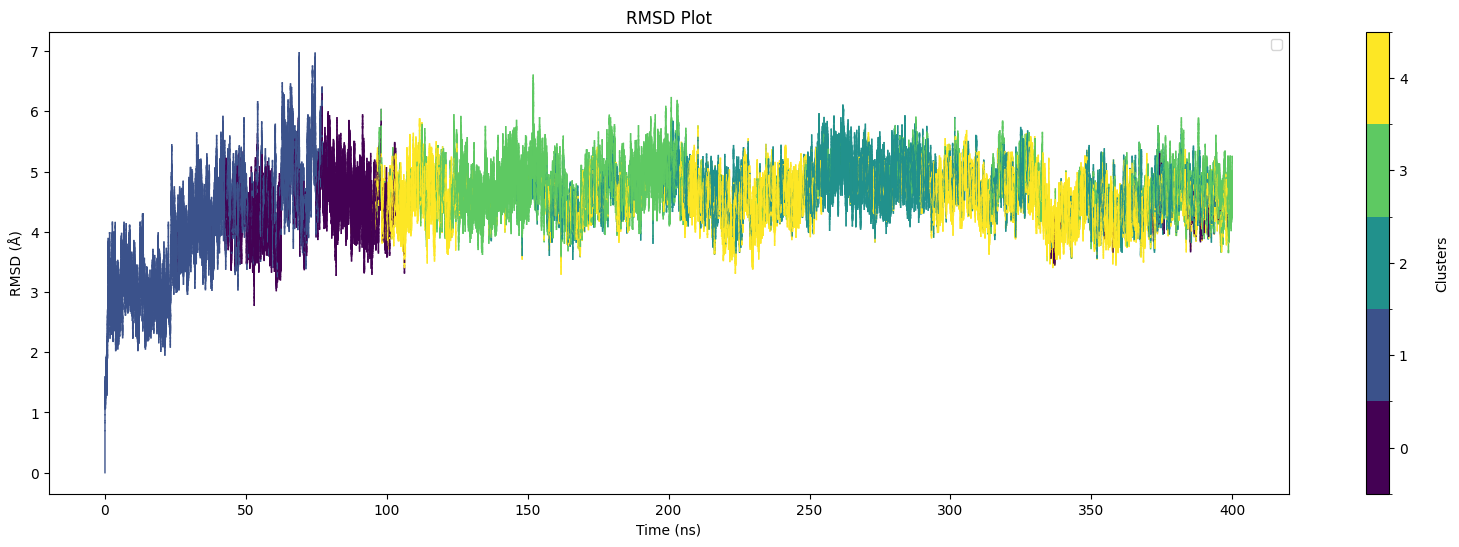

In [ ]:
# Calculate RMSD
def calculate_rmsd(reference, trajectory):
    diff = reference - trajectory
    return np.sqrt(np.mean(np.sum(diff ** 2, axis=1), axis=1))

# Create the RMSD Plot

# Create the reference trajectory
reference = traj.xyz[0]

# Compute RMSD
rmsd = calculate_rmsd(reference, traj.xyz) * 0.1

# Generate time array (assuming 0.5 ns per frame)
time = np.arange(len(rmsd)) * 0.002

# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))

# Find unique values in y_pred and sort them
y_unq = np.unique(y_pred)
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(y_unq))))

# Plot RMSD over time as a line plot
for i in range(1, len(time)):
    color_index = np.where(y_unq == y_pred[i-1])[0][0]
    ax.plot(time[i-1:i+1], rmsd[i-1:i+1], color=cmap(color_index), linewidth=1)

# Labels and title
ax.set_xlabel('Time (ns)')
ax.set_ylabel('RMSD (Å)')
plt.title('RMSD Plot')

# Create discrete colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_alpha(1)
cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Clusters', labelpad=20)

plt.legend()

# Show the plot
plt.show()


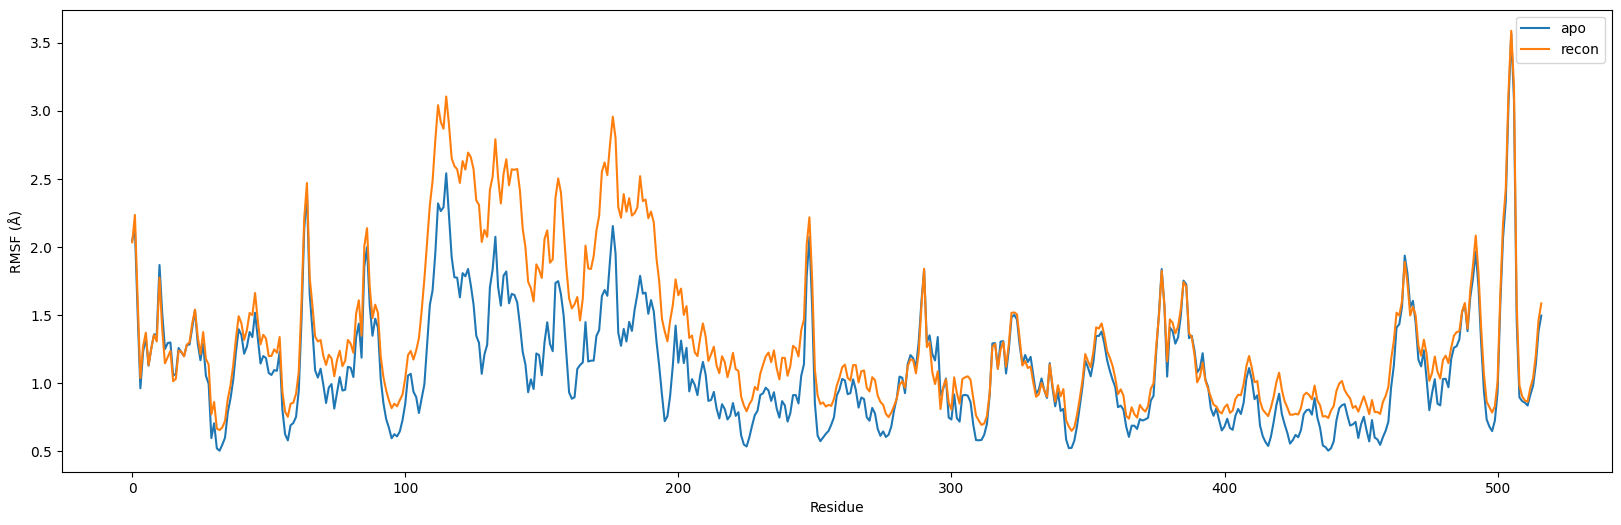

Text(0, 0.5, 'out')

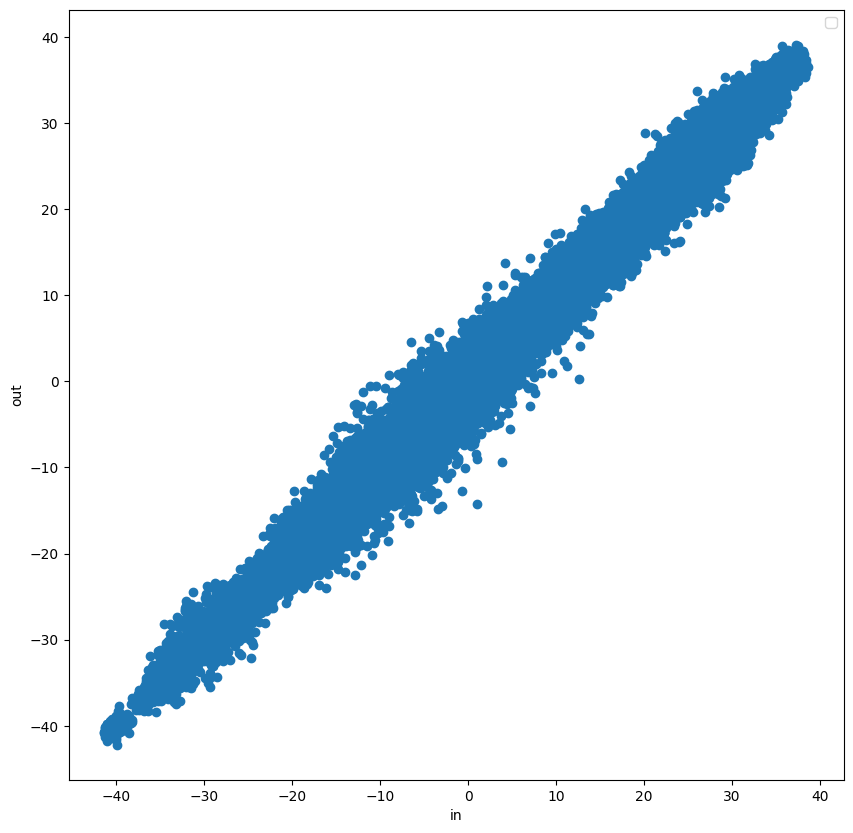

In [ ]:

apo_recon = md.Trajectory(x.reshape(len(x),-1,3) + np.mean(traj_apo.xyz, axis=0), topology=traj_apo.topology)

rmsf_apo = md.rmsf(traj_apo, traj_apo)
rmsf_recon = md.rmsf(apo_recon, apo_recon)

plt.figure(figsize=(20, 6))
plt.plot(rmsf_apo, label='apo')
plt.plot(rmsf_recon, label='recon')
plt.legend()
plt.xlabel('Residue')
plt.ylabel('RMSF (Å)')
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(traj_apo.xyz.flatten().flatten()[::1000], apo_recon.xyz.flatten().flatten()[::1000])
plt.legend()
plt.xlabel('in')
plt.ylabel('out')

In [ ]:
!pip install simpletraj

xtc_file = '/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_transition_1_3.xtc'
pdb_file = '/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb'

# Create an NGLView widget
view = nv.show_simpletraj(nv.SimpletrajTrajectory(xtc_file, pdb_file), gui=True)

view.add_representation(repr_type='tube', colorScheme = 'atomindex')
view._remote_call('setSize', target='Widget', args=['800px','600px'])
view


NGLWidget(max_frame=19)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
print(traj_apo.xyz)
print(apo_recon.xyz)

[[[-32.612385    -0.9482571    7.000986  ]
  [-29.012379    -2.2382572    7.450983  ]
  [-25.572384    -1.9482567    5.740984  ]
  ...
  [-23.102383   -24.888258     2.600985  ]
  [-25.342388   -23.25826      5.1709843 ]
  [-24.902386   -22.39826      8.800989  ]]

 [[-32.34161     -1.0252451    6.800812  ]
  [-28.751606    -2.435241     7.3908157 ]
  [-25.451603    -2.4452431    5.3408127 ]
  ...
  [-23.101612   -24.735243     2.050812  ]
  [-25.38161    -23.265242     4.8308105 ]
  [-24.88161    -22.535246     8.630814  ]]

 [[-31.908203    -1.0982999    8.268512  ]
  [-28.398201    -2.5683005    8.178508  ]
  [-25.268196    -2.878298     5.7385125 ]
  ...
  [-22.758202   -24.828302     2.3485134 ]
  [-24.908195   -23.6383       5.328509  ]
  [-24.608208   -22.508295     9.128512  ]]

 ...

 [[-31.814663     2.9370027    4.4307585 ]
  [-29.224667     0.38699964   5.5907545 ]
  [-25.724659    -0.90300125   4.270755  ]
  ...
  [-24.09467    -23.922998     0.89075786]
  [-27.064663   -2

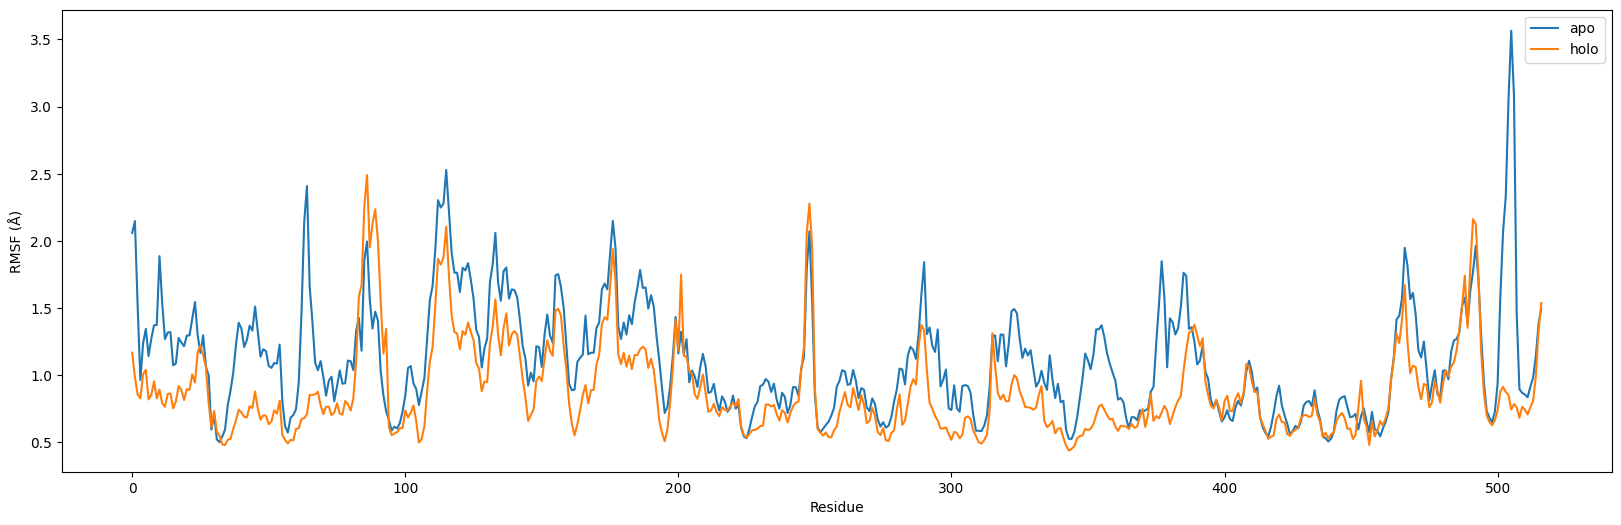

In [ ]:
apo_mean = md.Trajectory(np.mean(traj_apo.xyz, axis=0), topology=traj_apo.topology)
holo_mean = md.Trajectory(np.mean(traj_holo.xyz, axis=0), topology=traj_holo.topology)
rmsf_apo = md.rmsf(traj_apo, apo_mean)
rmsf_holo = md.rmsf(traj_holo, holo_mean)
plt.figure(figsize=(20, 6))
plt.plot(rmsf_apo, label='apo')
plt.plot(rmsf_holo, label='holo')
plt.legend()
plt.xlabel('Residue')
plt.ylabel('RMSF (Å)')
plt.show()

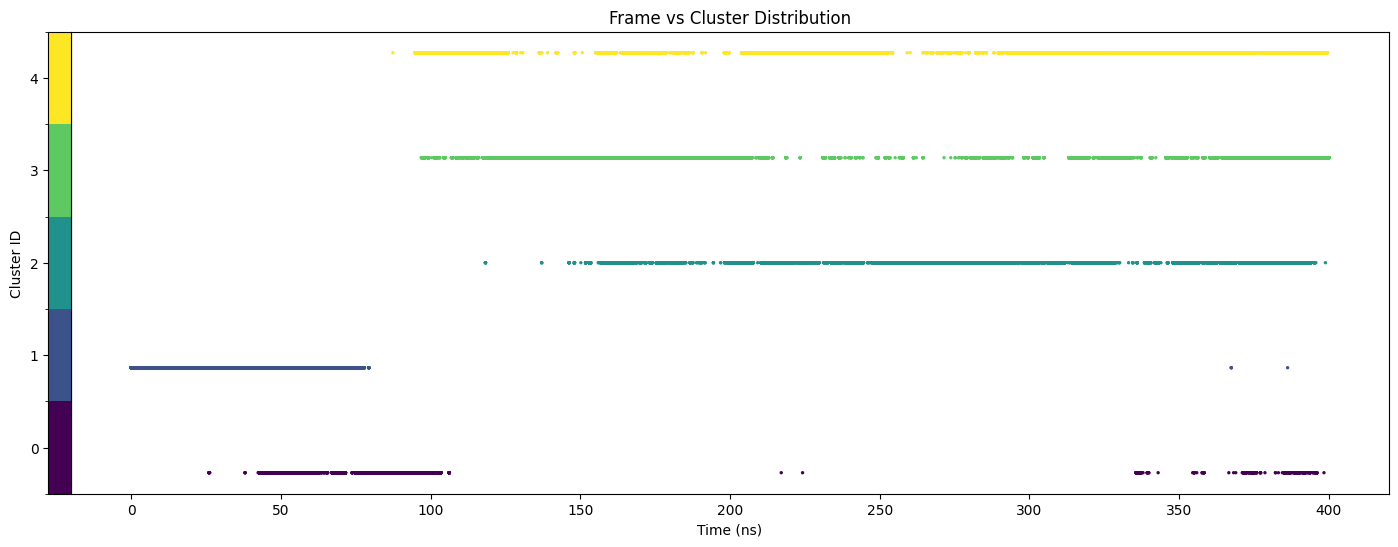

In [ ]:

# Create a grid of subplots
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(20, 6))

ax_main = plt.subplot(gs[0, 0])

# Scatter plot
cmap = plt.get_cmap('viridis', len(y_unq))  # get discrete colormap
boundaries = np.arange(len(y_unq) + 1) - 0.5  # setting boundaries
norm = BoundaryNorm(boundaries, cmap.N, clip=True)  # normalizing boundaries
sc = ax_main.scatter(np.arange(len(traj.xyz)) *0.002, y_pred, c=y_pred, cmap=cmap, norm=norm, s=2, alpha=1)

# Labels and title
ax_main.set_xlabel('Time (ns)')
ax_main.set_title('Frame vs Cluster Distribution')

# Remove y-axis ticks
ax_main.yaxis.set_ticks([])

# Colorbar on the left side
cbar = plt.colorbar(sc, ax=ax_main, ticks=np.arange(len(y_unq)), orientation='vertical', pad=0.0, location='left')
cbar.set_label('Cluster ID')

plt.show()


<ipython-input-12-836251f0939f>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(y_unq))  # Get 'viridis' colormap with discrete clusters


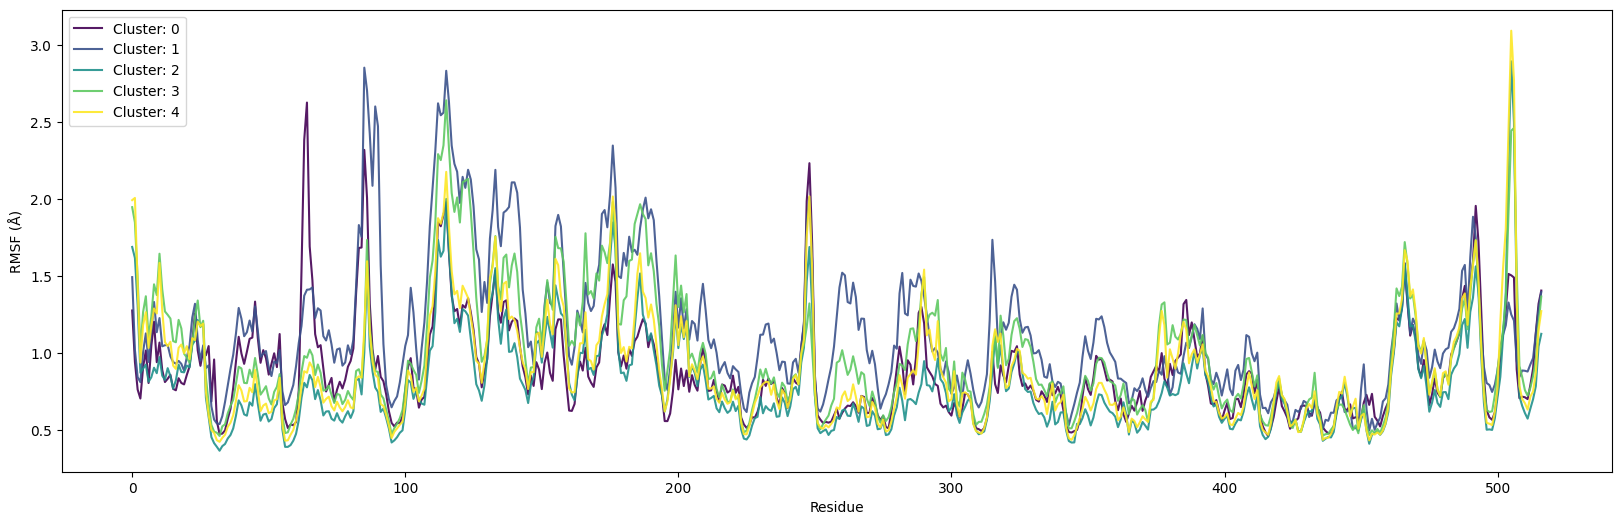

<ipython-input-12-836251f0939f>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(y_unq))  # Get 'viridis' colormap with discrete clusters


In [ ]:

import matplotlib.cm as cm

plt.figure(figsize=(20, 6))
cmap = cm.get_cmap('viridis', len(y_unq))  # Get 'viridis' colormap with discrete clusters

for i in range(len(y_unq)):

    idx = np.argwhere(y_pred == i)
    traj_i = md.Trajectory(traj.xyz[idx.flatten()], topology=traj.topology)
    traj_mean = md.Trajectory(np.mean(traj_i.xyz, axis=0), topology=traj.topology)
    rmsf = md.rmsf(traj_i, traj_mean)
    color = cmap(i)  # Assign a color from 'viridis' colormap

    plt.plot(rmsf, label=f"Cluster: {i}", color=color, alpha=0.9)  # Apply color

plt.legend()
plt.xlabel("Residue")
plt.ylabel("RMSF (Å)")
plt.show()

plt.figure(figsize=(20, 6))
cmap = cm.get_cmap('viridis', len(y_unq))  # Get 'viridis' colormap with discrete clusters

idx0 = np.argwhere(y_pred == 1).flatten()
idx4 = np.argwhere(y_pred == 4).flatten()
idx = np.concatenate((idx0, idx4), axis=0)
traj_i = md.Trajectory(traj.xyz[idx.flatten()], topology=traj.topology)
traj_mean = md.Trajectory(np.mean(traj_i.xyz, axis=0), topology=traj.topology)
rmsf = md.rmsf(traj_i, traj_mean)
color = cmap(i)  # Assign a color from 'viridis' colormap
plt.plot(rmsf, alpha=0.9, color='b')  # Apply color

idx1 = np.argwhere(y_pred == 0).flatten()
idx2 = np.argwhere(y_pred == 2).flatten()
idx3 = np.argwhere(y_pred == 3).flatten()
idx = np.concatenate((idx1, idx2, idx3), axis=0)
traj_i = md.Trajectory(traj.xyz[idx.flatten()], topology=traj.topology)
traj_mean = md.Trajectory(np.mean(traj_i.xyz, axis=0), topology=traj.topology)
rmsf = md.rmsf(traj_i, traj_mean)
color = cmap(i)  # Assign a color from 'viridis' colormap
plt.plot(rmsf, alpha=0.9, color='r')  # Apply color

plt.legend()
plt.xlabel("Residue")
plt.ylabel("RMSF (Å)")
plt.show()

In [ ]:
for i in range(len(y_unq)):
    idx = np.argwhere(y_pred == i)
    traj_i = md.Trajectory(traj.xyz[idx.flatten()], topology=traj.topology)
    traj_i.save_xtc(f"/content/drive/MyDrive/PhD/AI-ML/GMVAE/WTx2_apo_CA_ChainsA_cluster{i}.xtc")

print(traj_i.xyz.shape)


(59948, 517, 3)


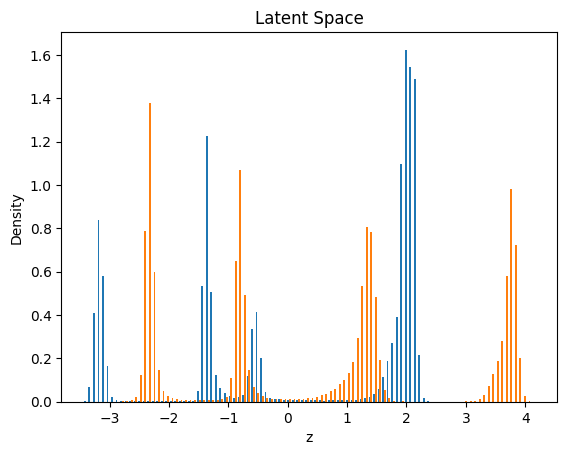

In [ ]:
#Latent Space (z) Plot
plt.hist(z, bins=100, alpha=1, density=True)
plt.ylabel('Density')
plt.xlabel('z')
plt.title('Latent Space')
plt.show()


In [ ]:
# Clusters
#qy = np.load('/content/qy.npy')
print(qy)
#qy=qy.numpy()

y_pred = np.argmax(qy, axis=1)
y_unq = np.unique(y_pred)
for i in range(len(y_unq)):
    y_pred[np.where(y_pred == y_unq[i])] = np.arange(0, len(y_unq))[i]

print("Clusters: ", y_unq)

tf.Tensor(
[[9.5054966e-28 1.0000000e+00 4.8222223e-37 4.8222223e-37 4.8222223e-37]
 [1.0831910e-28 1.0000000e+00 5.9720291e-37 5.9720291e-37 5.9720291e-37]
 [8.8217520e-28 1.0000000e+00 7.7583318e-37 7.7583318e-37 7.7583318e-37]
 ...
 [9.2005678e-22 9.2005678e-22 9.2005678e-22 1.0000000e+00 9.2005678e-22]
 [1.1323375e-20 1.1323375e-20 1.1323375e-20 1.0000000e+00 1.1323375e-20]
 [2.4108042e-20 2.4108042e-20 2.4108042e-20 1.0000000e+00 2.4108042e-20]], shape=(200001, 5), dtype=float32)
Clusters:  [0 1 2 3 4]


In [ ]:
# FEL Clustering Plot (2D)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sc = axes.scatter(data[::50, 0], data[::50, 1], c=y_pred[::50], alpha=1,
                  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)

cbar = fig.colorbar(sc, ax=axes)
cbar.set_alpha(1)
cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Cluster index', labelpad=20)

sc.set_alpha(1)
sc.set_clim(-0.5, len(np.unique(y_pred)) - 0.5)

axes.set_xlabel('X0', labelpad=20)
axes.set_ylabel('X1', labelpad=20)

plt.show()


<ipython-input-16-2eeea9460052>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)


In [ ]:
!pip install  deeptime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:00


In [ ]:
from deeptime.decomposition import TICA

tica = TICA(dim=2, lagtime=50)
tica_model = tica.fit(traj_apo.xyz.reshape(len(traj_apo.xyz), -1)).fetch_model()
t = tica_model.transform(traj_apo.xyz.reshape(len(traj_apo.xyz), -1))

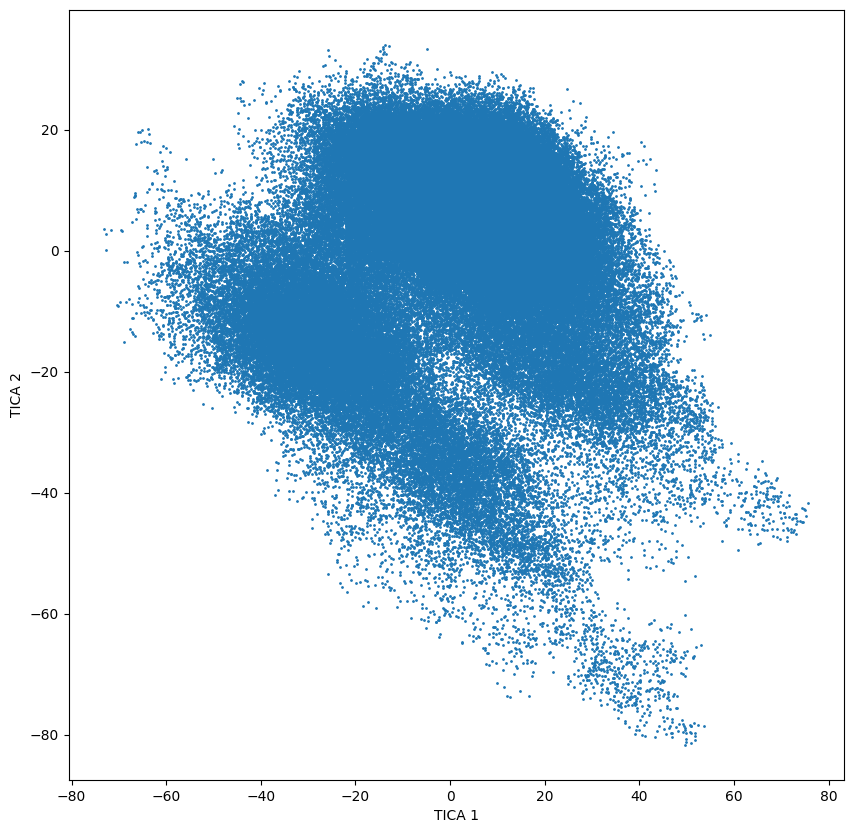

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(t[:, 0], t[:, 1], s=1)
plt.xlabel('TICA 1')
plt.ylabel('TICA 2')
plt.show()

import numpy as np
from scipy.linalg import eigh

def calculate_rmsf_eigenvectors(eigenvectors, eigenvalues, atom_mass):
    n_atoms = eigenvectors.shape[1] // 3
    nmodes = len(eigenvalues)
    y = np.zeros((nmodes, n_atoms))
    masses = atom_mass
    for g in range(nmodes):
        for i in range(n_atoms):
            norm2 = np.sum(eigenvectors[g, i*3:(i+1)*3]**2)
            eigval_w = eigenvalues[g] * norm2
            if eigval_w < 0:
                amplitude = 0.0
            else:
                amplitude = np.sqrt(eigval_w) / np.sqrt(3*masses[i])
            y[g, i] = amplitude
    if eigenvectors.shape[0] != eigenvectors.shape[1]:
        y = np.delete(y, np.arange(abs(eigenvectors.shape[0] - eigenvectors.shape[1])), axis=0)
    return y

def gmx_pca(traj, mass_weighting=True, n_components=3):
    """
    https://manual.gromacs.org/current/reference-manual/analysis/covariance-analysis.html

    Perform PCA on molecular dynamics trajectory data.

    Parameters:
    xtc_path (str): Path to the .xtc trajectory file.
    pdb_path (str): Path to the .pdb topology file.
    mass_weighting (bool, optional): If True, applies mass-weighting to the PCA. Default is True.
    n_components (int, optional): Number of principal components to project. Default is 3.

    Returns:
    tuple: Eigenvalues, eigenvectors, PCA projection of the trajectory, RMSF of eigenvectors, and covariance matrix.
    """
    if isinstance(traj, np.ndarray):
      n_atoms = traj.shape[1]
      coordinates = traj
    elif isinstance(traj, md.Trajectory):
      # Get the number of atoms
      n_atoms = traj.n_atoms

      # Extract the coordinates
      coordinates = traj.xyz

    # Center the coordinates by subtracting the mean position (over the trajectory)
    mean_position = np.mean(coordinates, axis=0)
    centered_coordinates = coordinates - mean_position

    # Construct the mass matrix M (if mass-weighting is desired)
    if mass_weighting:
        masses = np.repeat(12, 3*n_atoms)
        mass_matrix = np.diag(masses)
    else:
        if coordinates.ndim == 2:
            masses = np.repeat(1, n_atoms)
            mass_matrix = np.eye(n_atoms)
        else:
            masses = np.repeat(1, 3*n_atoms)
            mass_matrix = np.eye(3*n_atoms)

    # Flatten the centered coordinates
    flattened_coordinates = centered_coordinates.reshape(len(coordinates), -1)

    # Compute the covariance matrix C with mass weighting
    cov_matrix = np.cov(flattened_coordinates, rowvar=False)
    weighted_cov_matrix = np.dot(np.dot(mass_matrix**0.5, cov_matrix), mass_matrix**0.5)

    # Diagonalize the covariance matrix to get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(weighted_cov_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx].T

    # Project the trajectory onto the selected principal components
    pca_projection = np.dot(eigenvectors[:n_components, :], flattened_coordinates.T)

    # Calculate RMSF of the eigenvectors
    rmsf_eigvec = calculate_rmsf_eigenvectors(eigenvectors, eigenvalues, masses)

    return eigenvalues, eigenvectors, pca_projection, rmsf_eigvec, cov_matrix


_,_,proj,_,_ = gmx_pca(traj_apo, mass_weighting=True, n_components=2)
plt.figure(figsize=(10, 10))
plt.scatter(proj.T[:, 0], proj.T[:, 1], s=1)
plt.xlabel('TICA 1')
plt.ylabel('TICA 2')
plt.show()
